---
# Third Use Case - European Patents concerend with microelectronics and telecommunications
---

<a id="top"></a>
# Text Analysis, Keyword extraction and Topic Modelling
Using Abstracts from the patstat data set we aim to extract essential keywords which will act as suitable identifiers for Patents several fields. This will aid us in identifying regional knowledge bases and research hubs in a more automated fashion, at the moment keywords used for the search are suggested by experts. We will use a variety of approaches rooted in the research field of Natural Language Processing (NLP) and Textual Analysis as well as statistical modelling approaches which include:
- Latent Dirichlet Allocation
- Latent Semantiv Analysis
- Negative Matrix Factorization

This notebook follows a variety of online and printed sources which will be credited in the [bibliography](#bibl).
***

# Table of Content

1. [Get and prepare the data](#chap1)
2. [Vectorizer](#chap3)
3. [Topic Modelling](#chap4)
4. [Results and visualisations](#chap5)

# 1. Get and prepare the data
<a id="chap1"></a>
Here we focus on importing the data from the data base, introducing stopwords, stemming and lemmatization (even though we prioritized lemmatization) using part-of-speech tagging (pos tagging) to improve the lemmatization quality, we could construct some features regarding length, number of words or stopwords as suggested in [1].

In [1]:
# load packages
import numpy as np
import pandas as pd
import pickle
import nltk
import psycopg2 as db
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

In [2]:
# necessary packages for [10]
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LsiModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# defining stopwords and the lemmatizer based on: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
stop_words = nltk.corpus.stopwords.words('english')

stop_words.extend(['overall','result','end','likewise','present','method','invention','relates','also','lastly',
                       'firstly','include', 'includes', 'including','exclude','desired','according','embodiments','first','least',
                       'configured','time','certain','therefor','whose','receiving','following','steps','using','use','individual',
                       'needed','need','purpose','profile','n','said','may','wherein','target','determining','set','comprises',
                       '1','2','10','comprising','provide','provided','used','means','proceeded','proceed','one','two','second', '100', 'preferably',
                       'problem','to','be','solved','solution','jpo','ncipi','problems','means','for','solving','utility','discloses','provides',
                        '<id>','</id>','<br>','</br>','<p>','</p>','<ul>','</ul>','<ol>','</ol>','<li>','</li>','<p id=','num=',
                        '<img id=','file='])

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


# Init Lemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [4]:
# establish connection and read data from postgres
# source: https://pynative.com/python-postgresql-tutorial/
try:
    connection = db.connect(user = XXX,
                                  password = XXX,
                                  host = XXX,
                                  port = XXX,
                                  database = XXX)
    #connection.set_client_encoding('UTF8')
    cursor = connection.cursor()
    # 19 mio distinct abstracts, some are in there multiple times because of multiple ipcs (32mio)
    # with c08 the total is about 5mio
    cursor.execute("SELECT * from thesis.microelectronics WHERE appln_abstract_lg = 'en' and LENGTH(nuts) > 2")
    returnlist = []
    row = cursor.fetchone()
    returnlist.append(row)
    errorcnt = 0
    while row is not None:
        try:
            row = cursor.fetchone()
            if row is not None:
                #row['appln_abstract'] = stem.stemabstract(row['appln_abstract'])
                returnlist.append(row)
        except UnicodeDecodeError:
            errorcnt = errorcnt + 1
    print("Couldn't decode " + str(errorcnt) + " abstracts")
    record = returnlist
except (Exception, db.Error) as error :
    print ("Error while connecting to PostgreSQL", error)
finally:
    #closing database connection.
        if(connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

Couldn't decode 325 abstracts
PostgreSQL connection is closed


In [5]:
len(record)

180867

In [6]:
record[1000]

(16388120,
 'en',
 'The method involves generating a signaling message with an internet protocol (IP) address of a terminal (11) e.g. voice over IP (VoIP)-compatible landline telephone. The message is transmitted to a connection server (10) e.g. Session Initiation Protocol (SIP) proxy, of the terminal, and is provided for transmission to another terminal (21). Another signaling message with an IP address of the terminal (11) is received by the terminal (21). Connecting agents (14, 24) are implemented in corresponding security modules (12, 22), which are provided with microprocessor chips. An independent claim is also included for a system for initializing voice over internet protocol (VoIP) connection between two subscribers.',
 16388120,
 'H04L  29/06',
 16388120,
 'DE212',
 'DE')

In [8]:
# create a corpus
def makecorpus(record,stop_words):
    phrases = nltk.tokenize.sent_tokenize(record)
    #words = nltk.tokenize.word_tokenize(record)
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(record)
    # stopwords
    #stop_words = stop_words
    corpus = [] 
    for w in words:
        if not w.isnumeric():
            if len(w) > 2:
                if w.lower() not in stop_words: 
                    # because of the need to compare each entry to wordnet lemmatizer takes ages
                    #token = stemmer.stem(w.lower())
                    token = (lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w)))
                    id2word.add_documents([[token]])
                    corpus.append(token)
    #print(phrases)
    #print(words)
    #print(corpus)
    return corpus

In [9]:
# need to be able to perform this batchwise
corpuslist = []

for i in range(0, len(record)):
    dat = str(record[i][2]) # extract the column containing the abstract
    corpuslist.append(makecorpus(dat,stop_words))

In [18]:
#id2word.filter_extremes(no_below=5, no_above=0.95)#, keep_n=1000000)

In [13]:
print(id2word)

Dictionary(14201 unique tokens: ['cover', 'woven', 'layer', 'join', 'connect']...)


In [11]:
sentences = [record[i][2] for i in range(0,len(record))]

In [12]:
appids = [record[i][0] for i in range(0,len(record))]

In [13]:
ipcs = [record[i][4][0:4] for i in range(0,len(record))]

In [14]:
nuts = [record[i][6] for i in range(0,len(record))]

In [15]:
ctr = [record[i][7] for i in range(0,len(record))]

In [16]:
tokenslist = [','.join(corpuslist[i]) for i in range(0,len(corpuslist))]

In [20]:
del record

# 2. Vectorizers
<a id="chap3"></a>
We start by applying a simple bag of words vectorizer but will also use a tfidf weighted matrix. A one hot encoder would not proof beneficial for the approach at hand.

In [17]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in corpuslist]

# View
print(corpus[:1])

[[(0, 2), (1, 4), (2, 5), (3, 1), (4, 1), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 5), (20, 2), (21, 2), (22, 2), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 3), (30, 3), (31, 3), (32, 6), (33, 5), (34, 1), (35, 2), (36, 2)]]


In [18]:
id2word[2]

'terminal'

In [19]:
len(corpus)

180867

Here we use tfidf scoring again to look at important keywords of the overall corpus.

In [20]:
from gensim.models import TfidfModel

model = TfidfModel(corpus)  # fit model
tfidf_matrix = model[corpus]

In [24]:
# using the sklearn implementation based on https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created
def dummy_fun(doc):
    return doc

tfidf_vectorizer = TfidfVectorizer(analyzer='word',tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None) #, ngram_range=(1,1), max_features=10000, max_df=.9)

X_train_tfidf = tfidf_vectorizer.fit_transform(corpuslist)
# get the first vector out (for the first document)
first_vector_tfidfvectorizer = X_train_tfidf[0]

# 3. Topic Modelling
<a id="chap4"></a>
We want to classify an abstract based on their content. Topic modeling provides us with methods to organize, understand and summarize large collections of textual information. We will use a variety of approaches including LDA, NMF, LSA and UMAP in combination with general purpose classification (HDBSCAN and kmeans).


## 3.1. LDA
Latent Dirichlet Allocation is one of the key models in this domain. LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

![title](topical.png)

In [21]:
# hyperparameter tuning according to https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_matrix,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=7000,
                                           passes=5,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True
                                           ) # topics 15
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
    perp = lda_model.log_perplexity(tfidf_matrix)
    return coherence_model_lda.get_coherence(), perp

We perform grid search on the LDA model to find the best parameterization, we will use the number of topics for the other topic models as well.

In [22]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               #gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75))#
               corpus]
corpus_title = ['Entire Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': [],
                 'Perplexity': []
                }


# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    result = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(result[0])
                    model_results['Perplexity'].append(result[1])
                pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

Text(0.5, 1.0, 'Model Selection - Number of Topics')

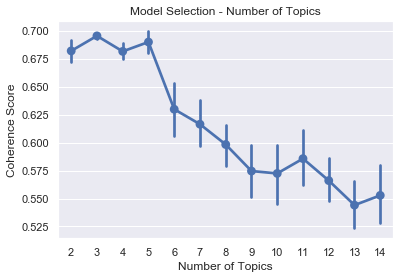

In [24]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.pointplot(x="Topics", y="Coherence", data=model_results)
ax.set(xlabel='Number of Topics', ylabel='Coherence Score')
ax.set_title("Model Selection - Number of Topics")

In [25]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf_matrix,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=2,
                                           chunksize=7000,
                                           passes=5,
                                           per_word_topics=True,
                                           alpha=0.31,
                                           eta = 0.91
                                           ) # topics 15

In [26]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(num_words=15))
#doc_lda = lda[corpus]

[(0,
  '0.011*"symbol" + 0.010*"channel" + 0.009*"data" + 0.009*"frame" + '
  '0.009*"bit" + 0.007*"block" + 0.006*"transmission" + 0.006*"sequence" + '
  '0.005*"sub" + 0.005*"carrier" + 0.005*"transmit" + 0.005*"signal" + '
  '0.005*"slot" + 0.005*"code" + 0.004*"packet"'),
 (1,
  '0.012*"network" + 0.010*"data" + 0.010*"station" + 0.009*"mobile" + '
  '0.009*"communication" + 0.008*"terminal" + 0.008*"node" + 0.007*"user" + '
  '0.007*"message" + 0.007*"device" + 0.007*"access" + 0.007*"information" + '
  '0.006*"service" + 0.006*"radio" + 0.006*"packet"'),
 (2,
  '0.020*"region" + 0.016*"layer" + 0.012*"transistor" + 0.012*"gate" + '
  '0.009*"semiconductor" + 0.008*"type" + 0.008*"zone" + 0.007*"form" + '
  '0.006*"substrate" + 0.006*"conductivity" + 0.006*"electrode" + '
  '0.006*"drain" + 0.006*"insulate" + 0.006*"source" + 0.006*"doped"'),
 (3,
  '0.020*"signal" + 0.011*"optical" + 0.010*"frequency" + 0.008*"output" + '
  '0.007*"circuit" + 0.007*"input" + 0.006*"filter" + 0.00

In [27]:
print('\nPerplexity:', lda_model.log_perplexity(tfidf_matrix))

coherence_score_lda = CoherenceModel(model=lda_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


Perplexity: -8.444421348782862

Coherence Score: 0.7254276561318876


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_matrix, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.176916 -0.151514       1        1  34.909382
4      0.186380 -0.041376       2        1  21.084736
3     -0.069979  0.090874       3        1  17.501682
2      0.173315 -0.004288       4        1  14.359037
0     -0.112800  0.106304       5        1  12.145162, topic_info=           Term         Freq        Total Category  logprob  loglift
87        layer  4193.000000  4193.000000  Default  30.0000  30.0000
88       region  2490.000000  2490.000000  Default  29.0000  29.0000
128      signal  3866.000000  3866.000000  Default  28.0000  28.0000
16      network  3498.000000  3498.000000  Default  27.0000  27.0000
890  transistor  1387.000000  1387.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
403      length   266.998566   477.655853   Topic5  -5.8974   1.5266
118    receiver   330.300964  1343.821533   Topic5  -5.6846   0.7050
237   frequency   337.236450  1843.674194   Topic5  -5.6639   0.4095
23      receive   287.485992  1431.600220   Topic5  -5.8235   0.5029
47       system   287.143250  2084.090088   Topic5  -5.8247   0.1261

[348 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
33240      1  0.012348  2des
33240      2  0.012348  2des
33240      3  0.012348  2des
33240      4  0.963138  2des
33240      5  0.012348  2des
...      ...       ...   ...
391        1  0.004926  zone
391        2  0.084726  zone
391        3  0.000985  zone
391        4  0.908346  zone
391        5  0.000985  zone

[1470 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

In [41]:
# look at the degree of assosciation
lda_model[corpus[60]] # corpus[0] means the first document.

([(0, 0.32423922), (4, 0.14465395), (5, 0.35536894), (9, 0.13740206)],
 [(0, [9, 5, 4, 0]),
  (3, [0, 4, 5, 9]),
  (27, [0, 5, 4]),
  (53, [5, 0, 4]),
  (73, [5, 0]),
  (110, [0, 4, 5, 9]),
  (124, [0, 4, 9]),
  (160, [0, 5, 4, 9]),
  (186, [4, 9, 5]),
  (195, [5, 0, 9, 4]),
  (207, [5, 0, 4, 9]),
  (254, [0, 5, 9, 4]),
  (267, [0, 5, 9]),
  (268, [5]),
  (269, [0, 5, 9]),
  (270, [4, 0]),
  (271, [0]),
  (272, [5, 0]),
  (273, [0, 5, 4, 9]),
  (274, [5, 9, 2]),
  (275, [5, 9, 0, 4]),
  (276, [9]),
  (277, [9, 4, 5, 0]),
  (278, [0, 9]),
  (279, [0, 5]),
  (280, [0, 9])],
 [(0, [(0, 0.31555897), (4, 0.34066236), (5, 0.57597274), (9, 0.7568671)]),
  (3, [(0, 0.43209663), (4, 0.2827313), (5, 0.22757924), (9, 0.054514747)]),
  (27, [(0, 1.7424473), (4, 0.09590853), (5, 1.1479263)]),
  (53, [(0, 0.28452787), (4, 0.039586563), (5, 0.6678447)]),
  (73, [(0, 0.011586719), (5, 1.9791244)]),
  (110, [(0, 0.64783984), (4, 0.1652708), (5, 0.14515059), (9, 0.03535578)]),
  (124, [(0, 1.0093812), (

## 3.2. NMF Model

In [29]:
from gensim.models.nmf import Nmf

nmf = Nmf(corpus=tfidf_matrix,
    id2word=id2word,
    num_topics=5,
    chunksize=2000,
    passes=5,
    random_state=42,
    normalize=True
)

In [30]:
nmf.show_topics(num_topics=10,num_words=15,formatted=False)

[(0,
  [('network', 0.018600250172232213),
   ('mobile', 0.016208081261717945),
   ('station', 0.016129423768227034),
   ('terminal', 0.01430468921308547),
   ('communication', 0.013917403304323386),
   ('access', 0.011863656839247545),
   ('user', 0.01153068331227815),
   ('message', 0.010443872602298393),
   ('service', 0.009823317727339775),
   ('radio', 0.009633241005617188),
   ('node', 0.009457518861130682),
   ('device', 0.008721944081754331),
   ('base', 0.008711622793229084),
   ('information', 0.008418624669166324),
   ('wireless', 0.007322260736375184)]),
 (1,
  [('signal', 0.02952141747303944),
   ('frequency', 0.013054867018035581),
   ('optical', 0.011013730660482298),
   ('receiver', 0.008024979106445264),
   ('transmission', 0.007724816358894032),
   ('channel', 0.007314151798267451),
   ('power', 0.006720164952247734),
   ('output', 0.006695542076882358),
   ('circuit', 0.006173290636313731),
   ('transmitter', 0.006124836144170879),
   ('phase', 0.006110279958546748),

In [31]:

coherence_score_nmf = CoherenceModel(model=nmf, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_nmf.get_coherence()

print('\nCoherence Score:', coherence_score)
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


Coherence Score: 0.6934871029669304


## 3.3. LSA

In [32]:
lsi_model = LsiModel(corpus, num_topics=5, id2word=id2word)
pprint(lsi_model.print_topics(num_words=20))

[(0,
  '0.382*"network" + 0.380*"data" + 0.284*"device" + 0.262*"signal" + '
  '0.255*"communication" + 0.163*"mobile" + 0.156*"station" + 0.151*"base" + '
  '0.150*"layer" + 0.148*"system" + 0.135*"information" + 0.126*"transmission" '
  '+ 0.126*"transmit" + 0.121*"node" + 0.120*"access" + 0.116*"user" + '
  '0.116*"control" + 0.111*"terminal" + 0.110*"channel" + 0.107*"radio"'),
 (1,
  '-0.747*"layer" + -0.219*"region" + -0.199*"form" + -0.198*"semiconductor" + '
  '-0.189*"substrate" + 0.149*"network" + 0.137*"data" + -0.132*"material" + '
  '-0.121*"surface" + -0.103*"contact" + -0.102*"structure" + -0.098*"gate" + '
  '-0.091*"electrode" + 0.090*"communication" + -0.080*"type" + '
  '-0.080*"silicon" + -0.074*"insulate" + -0.073*"transistor" + -0.065*"metal" '
  '+ 0.064*"mobile"'),
 (2,
  '-0.695*"signal" + 0.456*"network" + -0.162*"data" + 0.142*"communication" + '
  '0.141*"device" + 0.134*"access" + -0.132*"frequency" + 0.125*"node" + '
  '0.124*"mobile" + -0.114*"transmissio

In [33]:
coherence_score_lsi = CoherenceModel(model=lsi_model, texts=corpuslist, dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lsi.get_coherence()

print('\nCoherence Score:', coherence_score)


Coherence Score: 0.5744487361506041


# 4. Results and Visualisations
<a id="chap5"></a>
The last section visualizes the results from our final model (LDA for this use case). We will look at the technological concetration (dominant regional cluster compared to the general corpus cluster distribution) and relevant peer regions. We will also look at some abstracts using tagging and highlighting.

In [37]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=sentences, ids=appids, ipcs=ipcs, ctr=ctr, nuts=nuts):
    # Init output
    sent_topics_df = pd.DataFrame()
    sent_topics_list = []
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #row = row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #print(round(prop_topic,4))
                sent_topics_list.append([int(topic_num),round(prop_topic,4),topic_keywords])
            else:
                break
    #sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df=pd.DataFrame(sent_topics_list,columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    contents = pd.Series(texts[0:len(corpus)])
    appid = pd.Series(ids[0:len(corpus)])
    ipcs = pd.Series(ipcs[0:len(corpus)])
    ctr = pd.Series(ctr[0:len(corpus)])
    nuts = pd.Series(nuts[0:len(corpus)])
    sent_topics_df = pd.concat([sent_topics_df, contents,appid,ipcs,ctr,nuts], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=sentences, ids=appids,ipcs=ipcs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','ids','ipcs','ctr','nuts']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.9829   
1            1               1              0.9829   
2            2               1              0.9829   
3            3               1              0.9829   
4            4               1              0.9829   
5            5               1              0.9829   
6            6               1              0.9861   
7            7               4              0.9775   
8            8               4              0.9775   
9            9               1              0.9845   

                                            Keywords  \
0  network, data, station, mobile, communication,...   
1  network, data, station, mobile, communication,...   
2  network, data, station, mobile, communication,...   
3  network, data, station, mobile, communication,...   
4  network, data, station, mobile, communication,...   
5  network, data, station, mobile, communication,...   
6  network, data, station, mobile, communication,...   
7  layer, substrate, surface, material, semicondu...   
8  layer, substrate, surface, material, semicondu...   
9  network, data, station, mobile, communication,...   

                                                Text        ids  ipcs ctr  \
0  A mobile alert terminal (AT1; AT2; AT3) compri...  328736943  H04W  IT   
1  A mobile alert terminal (AT1; AT2; AT3) compri...  328736943  H04W  IT   
2  A mobile alert terminal (AT1; AT2; AT3) compri...  328736943  H04W  IT   
3  A mobile alert terminal (AT1; AT2; AT3) compri...  328736943  H04W  IT   
4  A mobile alert terminal (AT1; AT2; AT3) compri...  328736943  H04W  IT   
5  A mobile alert terminal (AT1; AT2; AT3) compri...  328736943  H04W  IT   
6  An embodiment of an apparatus (100) for assign...  333010707  H04W  DE   
7  The arrangement has a substrate (10) and a pow...  333342521  H01L  DE   
8  The arrangement has a substrate (10) and a pow...  333342521  H01L  DE   
9  Finally, there is provided a network device (2...  333462501  H04L  DE   

    nuts  
0  ITC4D  
1  ITC4D  
2  ITF34  
3  ITF34  
4  ITF35  
5  ITF35  
6  DE115  
7  DE254  
8  DE259  
9  DE21H

In [41]:
group = 4
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['Keywords'].iloc[0]

'layer, substrate, surface, material, semiconductor, contact, element, metal, component, form'

In [50]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group].sort_values(by=['Topic_Perc_Contrib']).tail(20)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
178100       178100               4              0.9961   
13643         13643               4              0.9967   
13645         13645               4              0.9967   
13646         13646               4              0.9967   
13644         13644               4              0.9967   
13642         13642               4              0.9967   
13640         13640               4              0.9967   
13639         13639               4              0.9967   
13638         13638               4              0.9967   
13636         13636               4              0.9967   
13635         13635               4              0.9967   
13634         13634               4              0.9967   
13633         13633               4              0.9967   
13632         13632               4              0.9967   
13631         13631               4              0.9967   
13641         13641               4              0.9967   
13637         13637               4              0.9967   
43838         43838               4              0.9969   
762             762               4              0.9969   
763             763               4              0.9969   

                                                 Keywords  \
178100  layer, substrate, surface, material, semicondu...   
13643   layer, substrate, surface, material, semicondu...   
13645   layer, substrate, surface, material, semicondu...   
13646   layer, substrate, surface, material, semicondu...   
13644   layer, substrate, surface, material, semicondu...   
13642   layer, substrate, surface, material, semicondu...   
13640   layer, substrate, surface, material, semicondu...   
13639   layer, substrate, surface, material, semicondu...   
13638   layer, substrate, surface, material, semicondu...   
13636   layer, substrate, surface, material, semicondu...   
13635   layer, substrate, surface, material, semicondu...   
13634   layer, substrate, surface, material, semicondu...   
13633   layer, substrate, surface, material, semicondu...   
13632   layer, substrate, surface, material, semicondu...   
13631   layer, substrate, surface, material, semicondu...   
13641   layer, substrate, surface, material, semicondu...   
13637   layer, substrate, surface, material, semicondu...   
43838   layer, substrate, surface, material, semicondu...   
762     layer, substrate, surface, material, semicondu...   
763     layer, substrate, surface, material, semicondu...   

                                                     Text        ids  ipcs  \
178100  The method comprises forming a first porous la...  381568999  H01L   
13643   The process comprises applying a moist materia...  315520769  H01L   
13645   The process comprises applying a moist materia...  315520769  H01L   
13646   The process comprises applying a moist materia...  315520769  H01L   
13644   The process comprises applying a moist materia...  315520769  H01L   
13642   The process comprises applying a moist materia...  315520769  H01L   
13640   The process comprises applying a moist materia...  315520769  H01L   
13639   The process comprises applying a moist materia...  315520769  H01L   
13638   The process comprises applying a moist materia...  315520769  H01L   
13636   The process comprises applying a moist materia...  315520769  H01L   
13635   The process comprises applying a moist materia...  315520769  H01L   
13634   The process comprises applying a moist materia...  315520769  H01L   
13633   The process comprises applying a moist materia...  315520769  H01L   
13632   The process comprises applying a moist materia...  315520769  H01L   
13631   The process comprises applying a moist materia...  315520769  H01L   
13641   The process comprises applying a moist materia...  315520769  H01L   
13637   The process comprises applying a moist materia...  315520769  H01L   
43838   The processing device (10) comprises an evacua...   57000108  H01L   
762 

In [52]:
j = 762
sentences[j]

'The processing device (10) comprises an evacuatable processing chamber (14) for receiving a process gas (44), a tempering device in sections in and/or in thermal operative connection with all walls of the processing chamber, a gas conveying device (46) for creating a gas flow cycle of a forced convection in the processing chamber, a heating device (36) for heating the gas, and a gas guiding device, which is configured for receiving the processed goods stack and is disposed in the processing chamber such that a part of the gas flow cycle is created or extends through the gas guiding device. The processing device (10) comprises an evacuatable processing chamber (14) for receiving a process gas (44), a tempering device in sections in and/or in thermal operative connection with all walls of the processing chamber, a gas conveying device (46) for creating a gas flow cycle of a forced convection in the processing chamber, a heating device (36) for heating the gas, a gas guiding device, whic

In [53]:
for i in id2word.doc2idx(corpuslist[j]):
    print(id2word[i])
    print(nmf.get_term_topics(i,minimum_probability = .3))

processing
[(2, 0.5316852483380458)]
device
[(0, 0.4001602770409491)]
evacuatable
[(4, 0.7536734719006267)]
processing
[(2, 0.5316852483380458)]
chamber
[(4, 0.9256046808043537)]
process
[(4, 0.4627321635308586)]
gas
[(4, 0.961805412255485)]
temper
[(4, 1.0)]
device
[(0, 0.4001602770409491)]
section
[(4, 0.3077430706751346)]
thermal
[(4, 0.8366789110503167)]
operative
[(1, 0.3121860246328852), (2, 0.36513510087574247)]
connection
[(0, 0.5721867000789234)]
wall
[(3, 0.45950383069402423), (4, 0.5374361974719578)]
processing
[(2, 0.5316852483380458)]
chamber
[(4, 0.9256046808043537)]
gas
[(4, 0.961805412255485)]
convey
[(0, 0.3684311218966439), (1, 0.32176595453607165)]
device
[(0, 0.4001602770409491)]
create
[]
gas
[(4, 0.961805412255485)]
flow
[(2, 0.7014214857364742)]
cycle
[(2, 0.5866622833936966)]
force
[(4, 0.5981804652243742)]
convection
[(4, 0.9254915696456493)]
processing
[(2, 0.5316852483380458)]
chamber
[(4, 0.9256046808043537)]
heating
[(4, 0.9369207094921361)]
device
[(0, 0.4

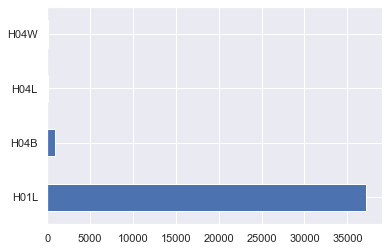

In [49]:
ax = df_dominant_topic[df_dominant_topic["Dominant_Topic"]==4]['ipcs'].value_counts()[:20].plot(kind='barh')

In [213]:
domipcs = pd.DataFrame(df_dominant_topic[df_dominant_topic["Dominant_Topic"]==group]['ipcs'].value_counts()[:20])

[Text(0, 0.5, 'Topic'), Text(0.5, 0, 'Number of Documents')]

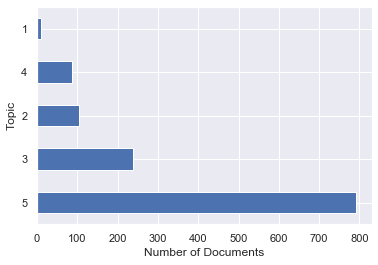

In [57]:
ax = df_dominant_topic[df_dominant_topic["nuts"].str.contains('AT22|AT21|AT31')]['Dominant_Topic'].value_counts()[:20].plot(kind='barh')
ax.set(xlabel='Number of Documents', ylabel='Topic')
#ax.set_title("Model Selection - Number of Topics")

In [56]:
# to stay consistent with the table contained in the thesis as topic 0 (which makes sense from a programming standpoint) is presented as topic 1
df_dominant_topic["Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]+1

In [58]:
ax = df_dominant_topic['Dominant_Topic'].value_counts()[:20].plot(kind='barh')
ax.set(xlabel='Number of Documents', ylabel='Topic')
#ax.set_title("Model Selection - Number of Topics")

[Text(0, 0.5, 'Topic'), Text(0.5, 0, 'Number of Documents')]

In [54]:
df_dominant_topic[df_dominant_topic["nuts"].str.contains('AT22|AT21|AT31')]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
768             768               4              0.9574   
769             769               4              0.9574   
770             770               4              0.9574   
771             771               4              0.9574   
1016           1016               1              0.9648   
...             ...             ...                 ...   
179844       179844               4              0.9637   
179845       179845               4              0.9637   
179846       179846               4              0.9637   
180315       180315               4              0.9643   
180316       180316               4              0.9643   

                                                 Keywords  \
768     layer, substrate, surface, material, semicondu...   
769     layer, substrate, surface, material, semicondu...   
770     layer, substrate, surface, material, semicondu...   
771     layer, substrate, surface, material, semicondu...   
1016    network, data, station, mobile, communication,...   
...                                                   ...   
179844  layer, substrate, surface, material, semicondu...   
179845  layer, substrate, surface, material, semicondu...   
179846  layer, substrate, surface, material, semicondu...   
180315  layer, substrate, surface, material, semicondu...   
180316  layer, substrate, surface, material, semicondu...   

                                                     Text        ids  ipcs  \
768     A LED module (1) comprises: \n - a LED chip (3...      59929  H01L   
769     A LED module (1) comprises: \n - a LED chip (3...      59929  H01L   
770     A LED module (1) comprises: \n - a LED chip (3...      59929  H01L   
771     A LED module (1) comprises: \n - a LED chip (3...      59929  H01L   
1016    The method involves assigning a portable devic...   16417612  H04W   
...                                                   ...        ...   ...   
179844  The light emitting device has a light emitting...   15831551  H01L   
179845  The light emitting device has a light emitting...   15831551  H01L   
179846  The light emitting device has a light emitting...   15831551  H01L   
180315  The device is provided with a film with an adh...  409586295  H01L   
180316  The device is provided with a film with an adh...  409586295  H01L   

       ctr   nuts  
768     AT  AT221  
769     AT  AT221  
770     AT  AT221  
771     AT  AT221  
1016    AT  AT315  
...     ..    ...  
179844  AT  AT221  
179845  AT  AT221  
179846  AT  AT221  
180315  AT  AT311  
180316  AT  AT311  

[1232 rows x 9 columns]

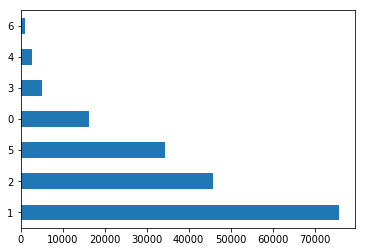

In [80]:
df_dominant_topic['Dominant_Topic'].value_counts()[:20].plot(kind='barh')

In [56]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==0]['ipcs'].value_counts()[:20].plot(kind='barh')

In [43]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==4]['nuts'].value_counts().to_csv("peers_micro.csv")

In [55]:
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==4]['nuts'].value_counts().head(40)

FR714    1992
DE212    1474
NL414    1455
BE242     934
DE21H     836
FR101     800
DED21     658
CH040     624
FR105     551
ITC4C     499
CH033     475
DE238     425
DE232     396
DE254     395
DE111     383
UKJ26     376
UKH12     376
DE300     361
DE719     355
FR104     330
DE218     323
DE252     305
FR103     268
DE112     264
ITC4D     255
DE115     238
AT221     234
DE131     230
DE257     228
DE248     219
DEA2D     219
DE264     210
FR107     204
CH024     200
CH011     194
FI1B1     186
DE259     185
DE214     178
ITG17     178
DE141     172
Name: nuts, dtype: int64

***
### Bibliography
<a id="bibl"></a>
[1] https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

[2] https://stevenloria.com/tf-idf/

[3] https://pynative.com/python-postgresql-tutorial/

[4] https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

[5] https://www.quora.com/How-are-TF-IDF-vectorizers-with-n-gram-features-created

[6] https://gdcoder.com/nlp-tutorial-topic-modeling-with-svd/

[7] https://gdcoder.com/all-you-need-to-know-about-nlp-text-preprocessing/

[8] Bengfort, B., Bilbro, R., & Ojeda, T. (2018). Applied Text Analysis with Python: Enabling Language-aware Data Products with Machine Learning. " O'Reilly Media, Inc.".

[9] Bird, S., Klein, E., & Loper, E. (2009). Natural language processing with Python: analyzing text with the natural language toolkit. " O'Reilly Media, Inc.".

[10] https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

[11] https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730

[12] https://github.com/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

***
#### [>>> return to top](#top)